# **Предсказание выживаемости пассажиров Титаника**

- **Исследовательский анализ данных (EDA)**
- **Предварительная обработка данных**
- **Построение и оценка модели логистической регрессии**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')


## **Загрузка данных**


In [2]:
train_df = pd.read_csv('train_1.csv')
test_df = pd.read_csv('test_1.csv')

train_df.head()


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## **Первоначальный анализ данных**


In [3]:
train_df.info()

train_df.describe()

train_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Примечание:** Видно, что в данных есть пропущенные значения в признаках **Age**, **Cabin** и **Embarked**.


## **Анализ целевой переменной**


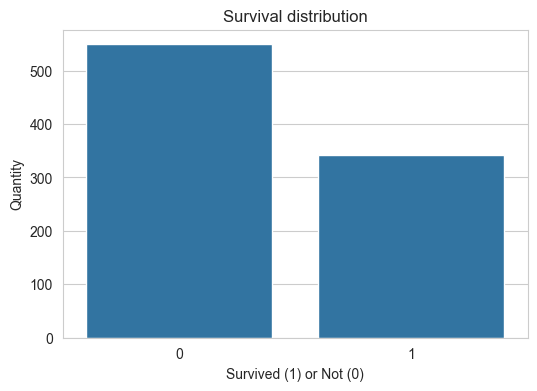

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='Survived')
plt.title('Survival distribution')
plt.xlabel('Survived (1) or Not (0)')
plt.ylabel('Quantity')
plt.show()

## **Анализ категориальных признаков**


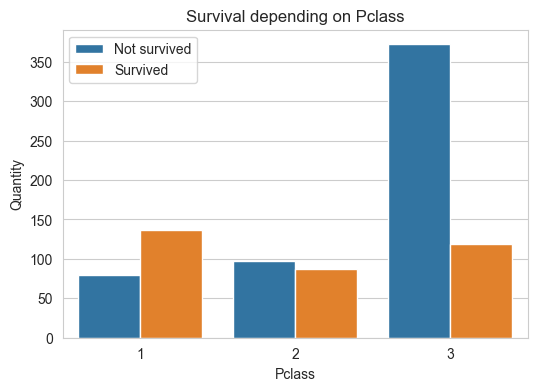

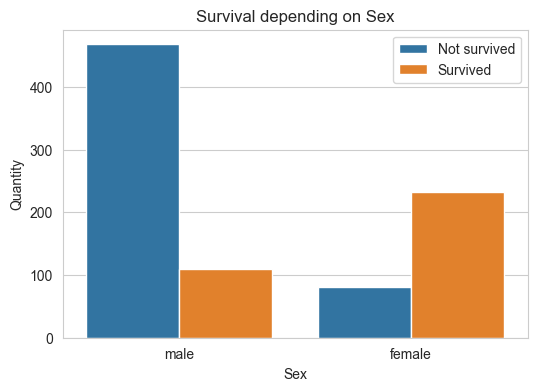

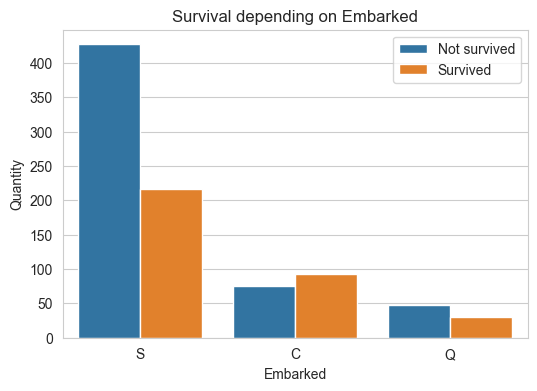

In [6]:
categorical_features = ['Pclass', 'Sex', 'Embarked']

for feature in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train_df, x=feature, hue='Survived')
    plt.title(f'Survival depending on {feature}')
    plt.xlabel(feature)
    plt.ylabel('Quantity')
    plt.legend(['Not survived', 'Survived'])
    plt.show()


## **Анализ числовых признаков**


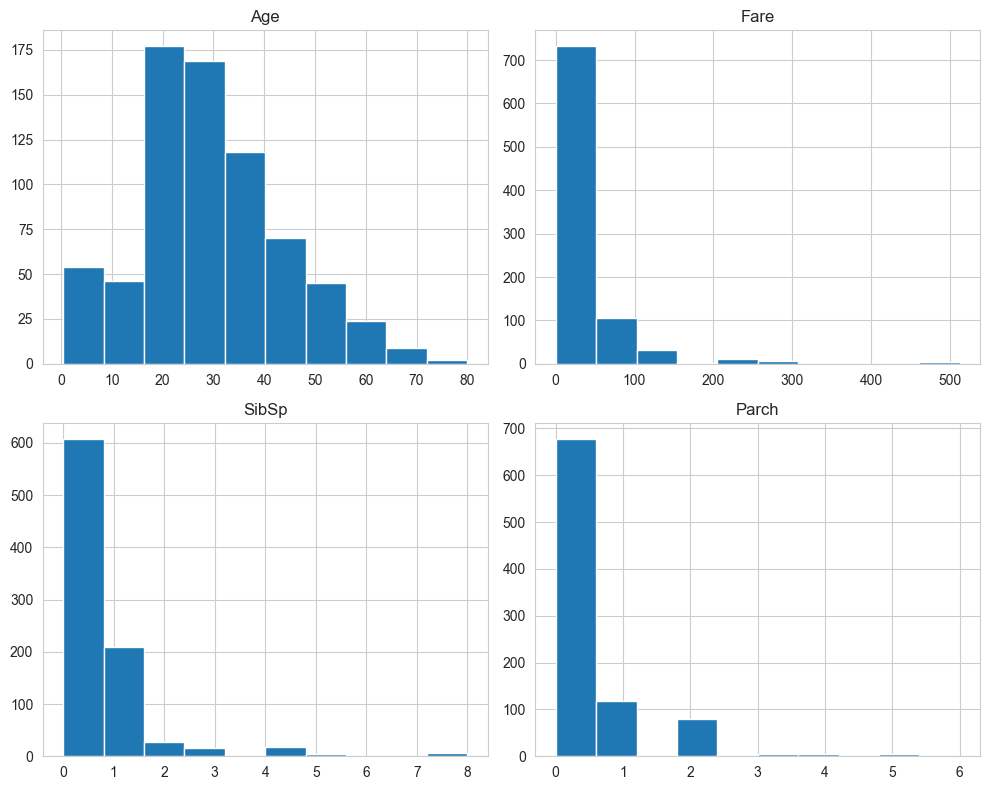

In [7]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

train_df[numerical_features].hist(figsize=(10,8))
plt.tight_layout()
plt.show()

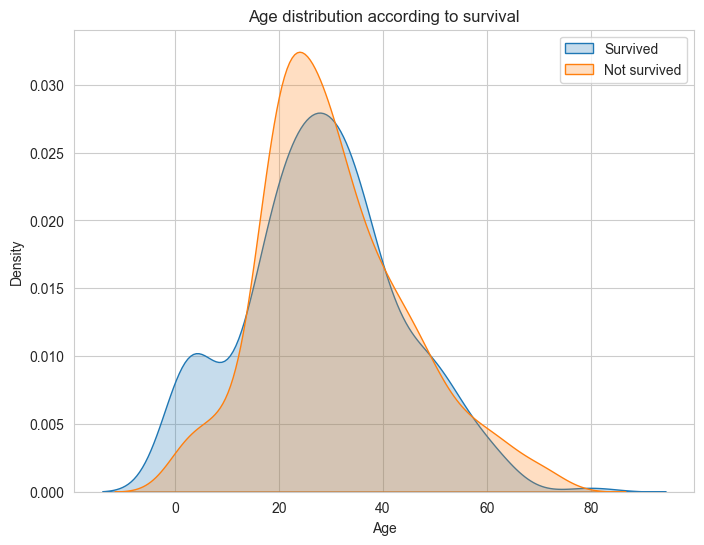

In [8]:
plt.figure(figsize=(8,6))
sns.kdeplot(train_df[train_df['Survived']==1]['Age'].dropna(), shade=True, label='Survived')
sns.kdeplot(train_df[train_df['Survived']==0]['Age'].dropna(), shade=True, label='Not survived')
plt.title('Age distribution according to survival')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


## **Корреляционная матрица числовых признаков**


Missing values in numerical features:
PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64


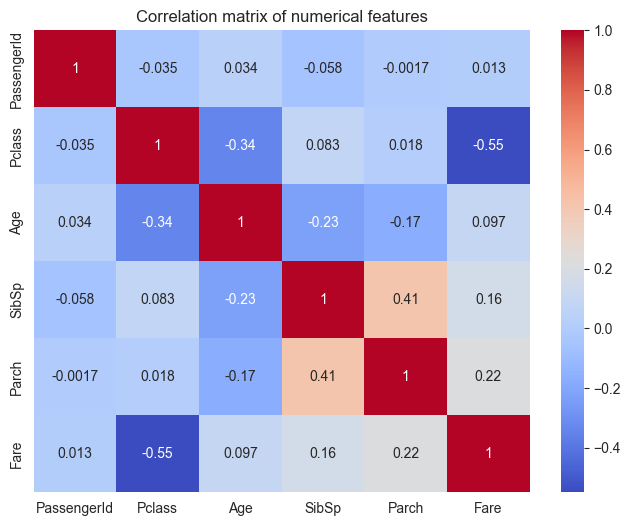

In [11]:
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop('Survived')

print("Missing values in numerical features:")
print(train_df[numeric_cols].isnull().sum())

train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of numerical features')
plt.show()

## **Предварительная обработка данных**


### **Обработка пропущенных значений**


In [14]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

### **Преобразование категориальных признаков**


In [15]:
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)

In [16]:
train_df['Pclass'] = train_df['Pclass'].astype(str)
test_df['Pclass'] = test_df['Pclass'].astype(str)

train_df = pd.get_dummies(train_df, columns=['Pclass'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Pclass'], drop_first=True)

### **Удаление ненужных признаков**


In [18]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

### **Проверка соответствия признаков в обучающем и тестовом наборах**


In [19]:
print("Training set columns:", train_df.columns)
print("Test set columns:", test_df.columns)


Training set columns: Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Pclass_2', 'Pclass_3'],
      dtype='object')
Test set columns: Index(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Pclass_2', 'Pclass_3'],
      dtype='object')


In [20]:
missing_cols = set(train_df.columns) - set(test_df.columns)
missing_cols.discard('Survived') 

for col in missing_cols:
    test_df[col] = 0

test_df = test_df[train_df.drop('Survived', axis=1).columns]

### **Разделение данных на признаки и целевую переменную**


In [21]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

### **Масштабирование признаков**


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df)

### **Разделение данных на обучающую и валидационную выборки**


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## **Построение и обучение модели**


In [24]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## **Оценка модели**


In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = logreg.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy on the validation set: {accuracy:.2f}')

Accuracy on the validation set: 0.80


In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


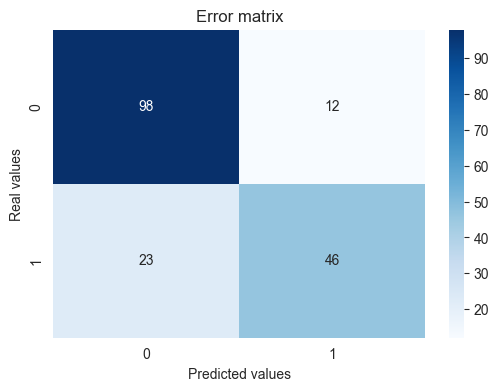

In [27]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Error matrix')
plt.ylabel('Real values')
plt.xlabel('Predicted values')
plt.show()

## **Анализ коэффициентов модели**


In [28]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
})

coefficients['abs_coef'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='abs_coef', ascending=False, inplace=True)

coefficients.drop('abs_coef', axis=1)

Feature  Coefficient
4    Sex_male    -1.263113
8    Pclass_3    -1.070370
0         Age    -0.493287
7    Pclass_2    -0.371656
1       SibSp    -0.270737
6  Embarked_S    -0.187460
3        Fare     0.128032
5  Embarked_Q     0.083381
2       Parch    -0.067470

## **Предсказания на тестовом наборе**


In [29]:
test_predictions = logreg.predict(test_scaled)

In [30]:
test_passenger_ids = pd.read_csv('test_1.csv')['PassengerId']

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions.astype(int)
})

submission.to_csv('submission.csv', index=False)
print("submission.csv has been saved")

submission.csv has been saved
